In [1]:
import matplotlib.pyplot as plt
import json

In [2]:
import torch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

In [5]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

In [6]:
from pts.model.deepar import DeepAREstimator
from pts.dataset.repository.datasets import dataset_recipes
from pts.modules import ZeroInflatedNegativeBinomialOutput

/opt/homebrew/lib/python3.10/site-packages/tensorflow_io-0.26.0-py3.10-macosx-12-arm64.egg/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/homebrew/lib/python3.10/site-packages/tensorflow_io-0.26.0-py3.10-macosx-12-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/opt/homebrew/lib/python3.10/site-packages/tensorflow_io-0.26.0-py3.10-macosx-12-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/homebrew/lib/python3.10/site-packages/tensorflow_io-0.26.0-py3.10-macosx-12-arm64.egg/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/homebrew/lib/python3.10/site-packages/tensorflow_io-0.26.0-py

In [7]:
dataset = get_dataset("pts_m5", regenerate=False)

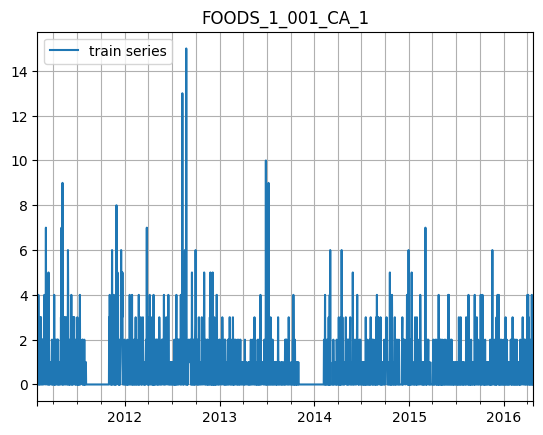

In [8]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.title(entry['item_id'])
plt.show()

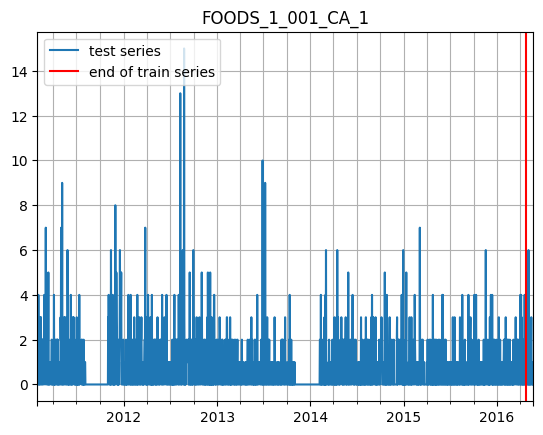

In [9]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.title(entry['item_id'])
plt.show()

In [10]:
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Recommended prediction horizon: 28
Frequency of the time series: D


In [11]:
estimator = DeepAREstimator(
    distr_output=ZeroInflatedNegativeBinomialOutput(),
    hidden_size=64,
    num_layers=3,
    dropout_rate=0.1,
#     num_feat_dynamic_real=4,
#     num_feat_static_cat=5,
#     cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
#     embedding_dimension = [4, 4, 4, 4, 16],
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    scaling="mean",
)

In [11]:
predictor = estimator.train(dataset.train)

In [18]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│   1 forecast_it, ts_it = make_evaluation_predictions(                                            │
│   2 │   dataset=dataset.test,  # test dataset                                                    │
│ ❱ 3 │   predictor=predictor,  # predictor                                                        │
│   4 │   num_samples=100,  # number of sample paths we want for evaluation                        │
│   5 )                                                                                            │
│   6                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'predictor' is not defined

ERROR! Session/line number was not unique in database. History logging moved to new session 588


In [24]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [25]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 30490/30490 [00:00<00:00, 72825.91it/s]


In [26]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4.9831022580643065,
    "abs_error": 837355.0,
    "abs_target_sum": 1231764.0,
    "abs_target_mean": 1.4428196598416343,
    "seasonal_error": 1.1272178349378457,
    "MASE": 0.9153679082981667,
    "MAPE": 0.7800716220446275,
    "sMAPE": 1.5507582107846607,
    "OWA": NaN,
    "MSIS": 8.01609371056141,
    "QuantileLoss[0.1]": 232214.80000000002,
    "Coverage[0.1]": 0.006127301691421073,
    "QuantileLoss[0.2]": 432821.2,
    "Coverage[0.2]": 0.019133908072904462,
    "QuantileLoss[0.3]": 603271.6,
    "Coverage[0.3]": 0.04252096706180011,
    "QuantileLoss[0.4]": 739940.8,
    "Coverage[0.4]": 0.0828257508316544,
    "QuantileLoss[0.5]": 837355.0,
    "Coverage[0.5]": 0.14760460104015366,
    "QuantileLoss[0.6]": 889230.8,
    "Coverage[0.6]": 0.2332122944290868,
    "QuantileLoss[0.7]": 880199.2,
    "Coverage[0.7]": 0.3683186524855924,
    "QuantileLoss[0.8]": 790916.0000000001,
    "Coverage[0.8]": 0.553399240968936,
    "QuantileLoss[0.9]": 578007.2,
    "Coverag

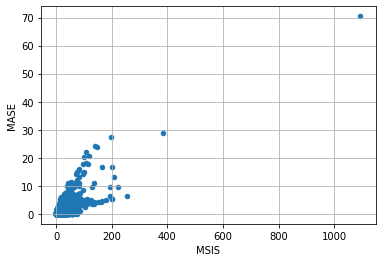

In [27]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()